# The Oslo Model (Self-organized Criticality)

In [1]:
from OsloModel import OsloModel
from OsloModelNumba import OsloModelNumba
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
import timeit
from time import time

In [2]:
L = 100
grains = 1000

In [3]:
%%timeit
OsloModel(L=L, grains=grains)

1.99 µs ± 35.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [4]:
%%timeit
OsloModelNumba(L=L, grains=grains)

The slowest run took 5.72 times longer than the fastest. This could mean that an intermediate result is being cached.
18.8 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
model = OsloModel(L=L, grains=grains)
modelNumba = OsloModelNumba(L=L, grains=grains)

In [6]:
%%timeit
model.add_all_grains(random_increment=True)

5.22 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
modelNumba.add_all_grains(True)

4.61 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Avalanche size in function of time

In [8]:
L = 2000
grains = 4000
random_increment = True
modelNumba = OsloModelNumba(L=L, grains=grains)

In [9]:
start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
time_delta

3.621002197265625

In [10]:
steps, avalanche = modelNumba.get_plot_data()
print(len(steps), len(avalanche))

4000 4000


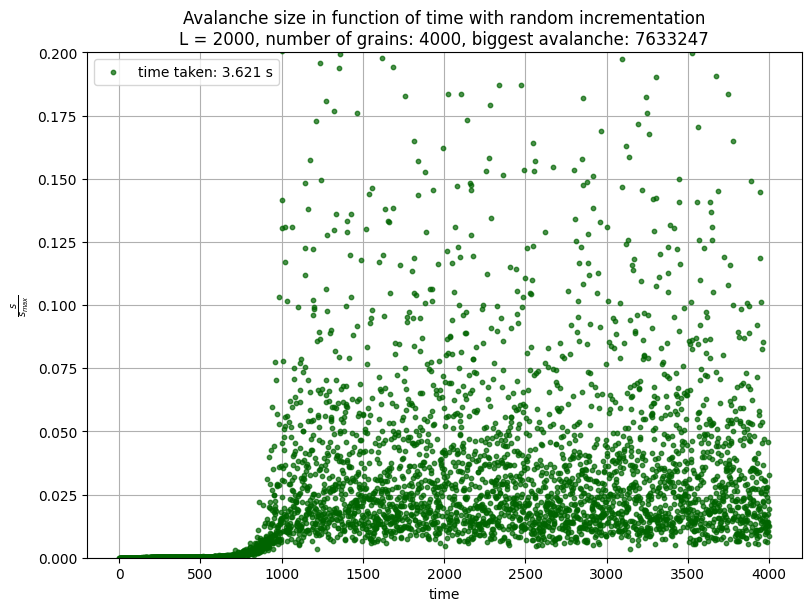

In [11]:
figure1, axes1 = plt.subplots(layout='constrained', figsize=(8, 6))
axes1.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.7,
             color='darkgreen')
axes1.set(title=f'Avalanche size in function of time with random incrementation\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, .2])
axes1.grid()
axes1.set_axisbelow(True)
axes1.legend(loc='upper left')

In [12]:
figure1.savefig(f'images/AvalancheSizeRandomL{L}G{grains}.png')

In [13]:
L = 4000
grains = 8000
random_increment = False
modelNumba = OsloModelNumba(L=L, grains=grains)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

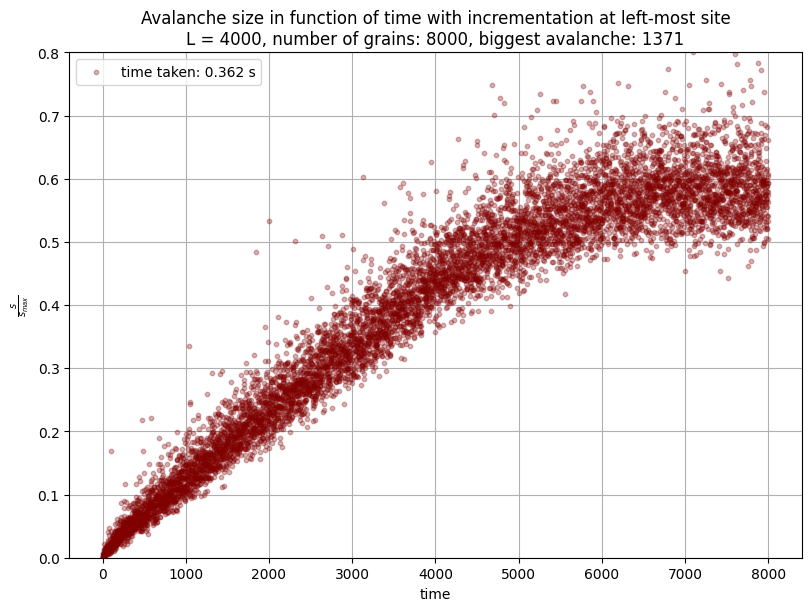

In [14]:
figure2, axes2 = plt.subplots(layout='constrained', figsize=(8, 6))
axes2.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.3,
             color='maroon')
axes2.set(title=f'Avalanche size in function of time with incrementation at left-most site\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, .8])
axes2.grid()
axes2.set_axisbelow(True)
axes2.legend(loc='upper left')

In [15]:
figure2.savefig(f'images/AvalancheSizeLeftmostL{L}G{grains}.png')

## We can also notice a sinusoidal behavior for larger number of grains

In [16]:
L = 1000
grains = 20000
random_increment = False
modelNumba = OsloModelNumba(L=L, grains=grains)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

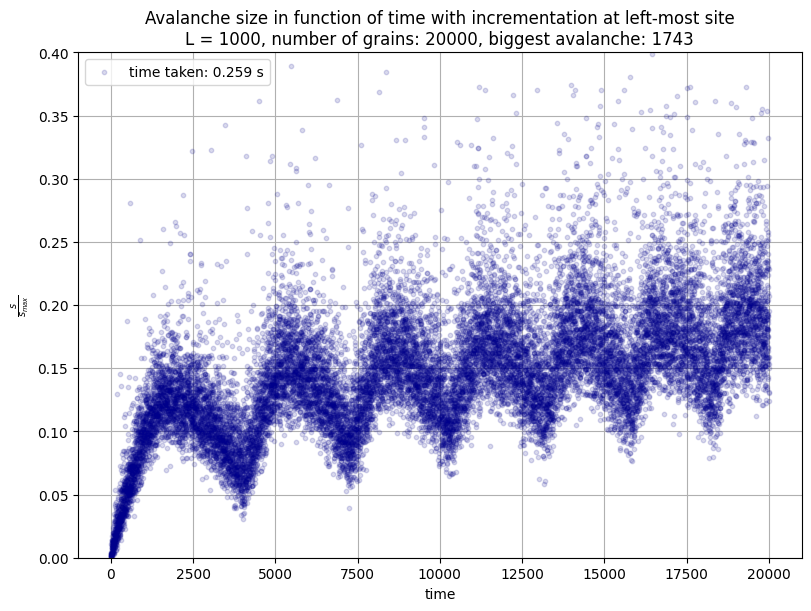

In [17]:
figure3, axes3 = plt.subplots(layout='constrained', figsize=(8, 6))
axes3.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.15,
             color='darkblue')
axes3.set(title=f'Avalanche size in function of time with incrementation at left-most site\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, .4])
axes3.grid()
axes3.set_axisbelow(True)
axes3.legend(loc='upper left')

In [18]:
figure3.savefig(f'images/AvalancheSizeLeftmostL{L}G{grains}.png')

# Avalanche size probability

In [19]:
@nb.njit()
def add_vectors(vector1: nb.int32[:], vector2: nb.int32[:]) -> nb.int32[:]:
    if len(vector1) > len(vector2):
        vector3 = vector1.copy()
        vector3[:len(vector2)] += vector2
    else:
        vector3 = vector2.copy()
        vector3[:len(vector1)] += vector1
    return vector3

In [20]:
def calculate_avalanche_probabilities(L, grains, trials, random_increment):
    osloModel = OsloModelNumba(L=L, grains=grains)
    avalanche_count = np.array([]).astype(np.int32)
    for trial in range(trials):
        osloModel.add_all_grains(random_increment)
        steps, avalanche = osloModel.get_plot_data()
        avalanche_count = add_vectors(avalanche_count, np.bincount(avalanche).astype(np.int32))
    return avalanche_count / np.sum(avalanche_count)

In [21]:
%%timeit
calculate_avalanche_probabilities(400, 2000, 10, False)

104 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
L_list = [150, 300, 500, 1000, 2000]
grains = 6000
colors = ['maroon', 'darkgreen', 'darkblue', 'gold', 'indigo']
trials = 100
is_incremented_randomly = False

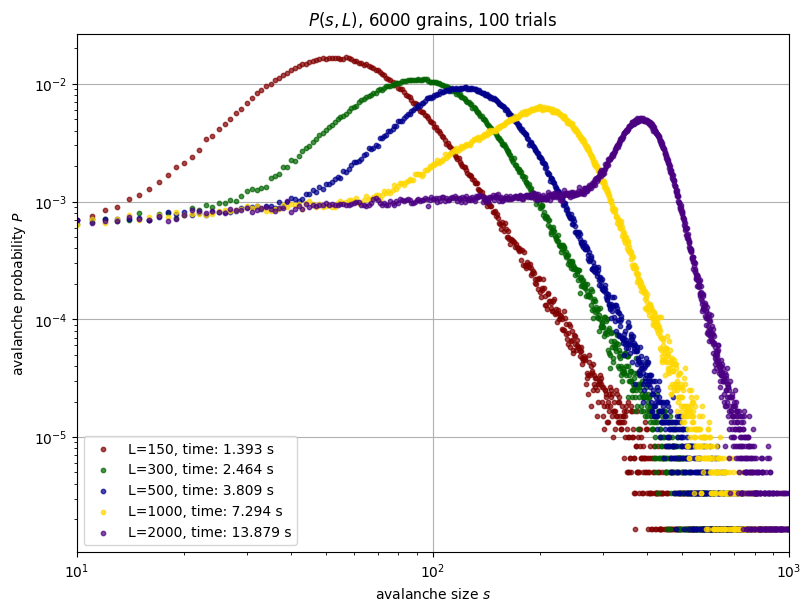

In [23]:
figure4, axes4 = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
for index, L in enumerate(L_list):
    start_time = time()
    avalanche_count = calculate_avalanche_probabilities(L_list[index], 
                                                        grains, 
                                                        trials, 
                                                        is_incremented_randomly)
    time_delta = time() - start_time
    axes4.scatter(np.arange(len(avalanche_count)), avalanche_count,
                 color=colors[index],
                 s=10,
                 label=f'L={L}, time: {time_delta:.3f} s',
                 alpha=.7)
    axes4.set(title=f'$P(s, L)$, {grains} grains, {trials} trials',
             xlabel='avalanche size $s$',
             ylabel='avalanche probability $P$',
             xscale='log', yscale='log',
             xlim=[10, 1000])
    axes4.legend(loc='lower left')
    axes4.grid()
    axes4.set_axisbelow(True)

In [24]:
figure4.savefig(f'images/AvalancheProbabilityLeftmostL{L}G{grains}T{trials}.png')

# System's time evolution visualization

In [25]:
def simulate_time_evolution(L, grains, is_randomly_incremented, threshold=tuple([2])):
    osloModel = OsloModelNumba(L=L, grains=grains, threshold=threshold)
    grid = osloModel.get_current_grid().copy()[:, None]
    for grain in range(grains):
        if is_randomly_incremented:
            osloModel.increment_randomly()
        else:
            osloModel.increment_top_left()
        grid = np.concatenate((grid, osloModel.get_current_grid()[:, None]), axis=1, dtype=np.int8)
        osloModel.system_relaxation()
        grid = np.concatenate((grid, osloModel.get_current_grid()[:, None]), axis=1, dtype=np.int8)
    steps, avalanche = osloModel.get_plot_data()
    return grid, steps, avalanche

In [26]:
def plot_time_evolution(L, steps, grid, axes=None, cmap='ocean'):
    if axes:
        vmax, vmin = 1, 0
        axes.pcolormesh(np.arange(0, steps + 0.5, 0.5), np.arange(L), grid[::-1, :], 
                        cmap=cmap, vmin=vmin, vmax=vmax)
        axes.set(xlabel='time', yticks=[])

In [27]:
def plot_avalanche_size(steps, steps_array, avalanche, axes=None, ylim=1):
    if axes:
        axes.scatter(steps_array, avalanche / avalanche.max(), s=7, alpha=.5, color='black')
        axes.set(ylim=[0, ylim], xlim=[0, steps])
        axes.set_yticklabels('')
        axes.set_xticklabels('')
        axes.tick_params(axis='both', direction='out', length=0)
        axes.grid()
        axes.set_axisbelow(True)

In [28]:
L = 500
steps = 500
is_incremented_randomly = True
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche sizes with random incrementation\nL=500, 500 grains, biggest_avalanche: 221311, ylim=0.1')

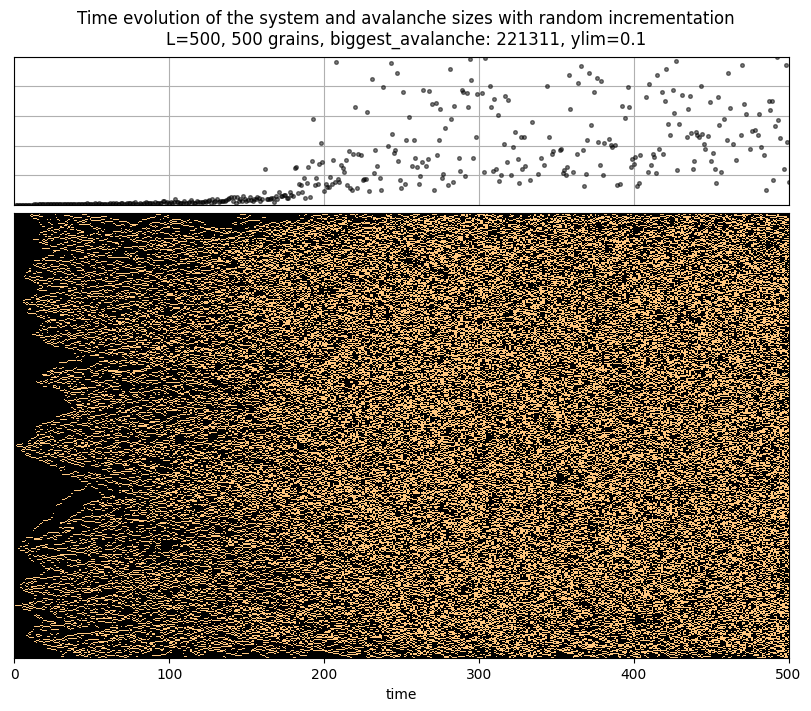

In [29]:
ylim = 0.1
figure5, axes5 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes5[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes5[1], cmap='copper')
figure5.suptitle(f'Time evolution of the system and avalanche sizes with random incrementation\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [30]:
figure5.savefig(f'images/SystemVisualizationRandomL{L}G{steps}.png')

In [31]:
L = 500
steps = 1000
is_incremented_randomly = False
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche sizes with left-site incrementation\nL=500, 1000 grains, biggest_avalanche: 254, ylim=0.6')

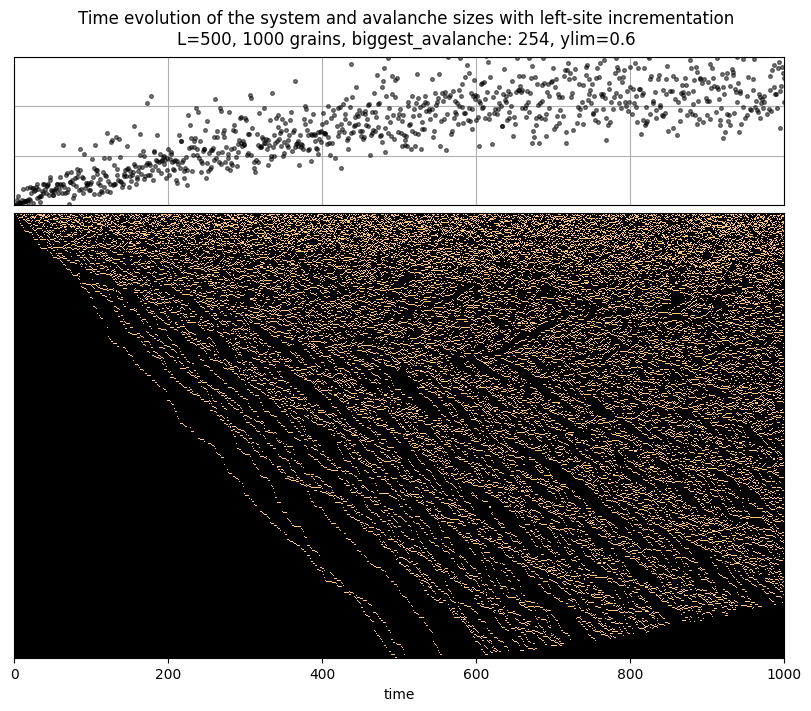

In [32]:
ylim = 0.6
figure6, axes6 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes6[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes6[1], cmap='copper')
figure6.suptitle(f'Time evolution of the system and avalanche sizes with left-site incrementation\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [33]:
figure6.savefig(f'images/SystemVisualizationLeftmostL{L}G{steps}.png')

In [34]:
L = 500
steps = 5000
is_incremented_randomly = False
evo_grid, steps_array, avalanche = simulate_time_evolution(L, steps, is_incremented_randomly, threshold=(1, 2))

Text(0.5, 0.98, 'Time evolution of the system and avalanche sizes with left-site incrementation\nL=500, 5000 grains, biggest_avalanche: 659, ylim=0.4')

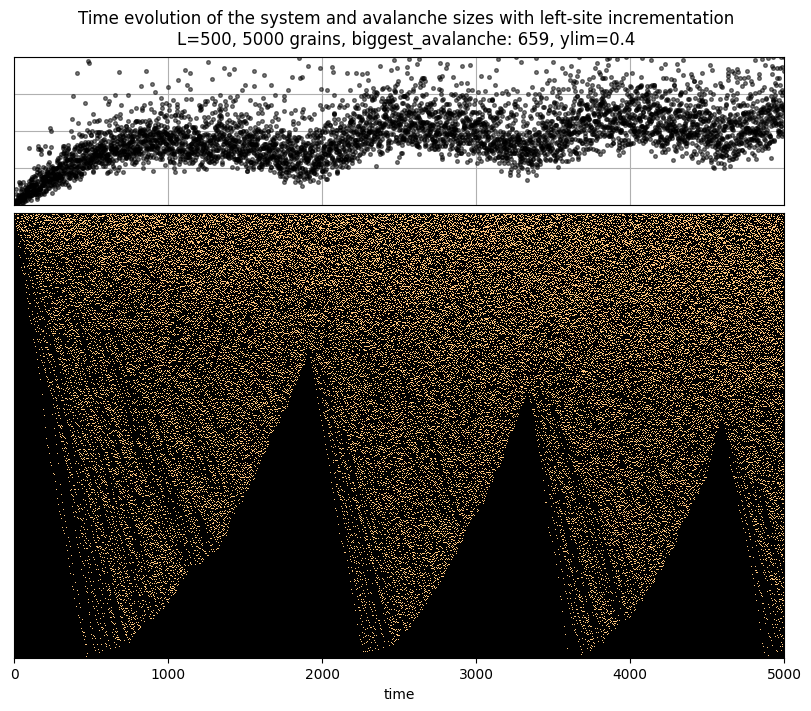

In [35]:
ylim = 0.4
figure7, axes7 = plt.subplots(2, 1, layout='constrained', height_ratios=[1, 3], figsize=(8, 7))
plot_avalanche_size(steps, steps_array, avalanche, axes=axes7[0], ylim=ylim)
plot_time_evolution(L, steps, evo_grid, axes=axes7[1], cmap='copper')
figure7.suptitle(f'Time evolution of the system and avalanche sizes with left-site incrementation\n'
                 f'L={L}, {steps} grains, biggest_avalanche: {avalanche.max()}, ylim={ylim}')

In [36]:
figure7.savefig(f'images/SystemVisualizationLeftmostL{L}G{steps}.png')